# Dataset 1 – Ransomware vs Benign

Static PE-Header Feature Classification

This notebook evaluates Random Forest, XGBoost, and SVM models on Dataset 1.
Primary evaluation metric: MCC.
Interpretability: SHAP (tree-based models).

## 1. Imports and Configuration

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay, make_scorer, matthews_corrcoef
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline


from xgboost import XGBClassifier



from scipy.stats import randint as sp_randint




SECTION 2 — Load Dataset

In [5]:
#Import dataset from Kaggle
%matplotlib inline
import matplotlib.pyplot as plt
df = pd.read_csv("../data/ransom_vs_benign.csv")

In [5]:

#Analyzing dataset
print(df.head())
print(df.info())

                                            FileName  \
0           0124e21d-018c-4ce0-92a3-b9e205a76bc0.dll   
1       05c8318f98a5d301d80000009c316005.vertdll.dll   
2           06054fba-5619-4a86-a861-ffb0464bef5d.dll   
3        075822ac99a5d301660400009c316005.adhapi.dll   
4  090607dd9ba5d301ca0900009c316005.SensorsNative...   

                            md5Hash  Machine  DebugSize  DebugRVA  \
0  79755c51e413ed3c6be4635fd729a6e1      332          0         0   
1  95e19f3657d34a432eada93221b0ea16    34404         84    121728   
2  85c32641d77a54e19ba8ea4ab305c791      332          0         0   
3  62e3b959d982ef534b66f819fe15f085    34404         84     19904   
4  ae38c5f7d313ad0ff3bfb8826476767f    34404         84     97728   

   MajorImageVersion  MajorOSVersion  ExportRVA  ExportSize  IatVRA  \
0                  0               4          0           0    8192   
1                 10              10     126576        4930       0   
2                  0               

- By analyzing the structure of the dataset I decided to **drop** FileName and md5Hash from feature set once its time to create a test set. 
- They serve as identifiers and the model would just memorize, not generalize

In [6]:
df.describe()

,Machine,DebugSize,DebugRVA,MajorImageVersion,MajorOSVersion,ExportRVA,ExportSize,IatVRA,MajorLinkerVersion,MinorLinkerVersion,NumberOfSections,SizeOfStackReserve,DllCharacteristics,ResourceSize,BitcoinAddresses,Benign
count,62485.000000,6.248500e+04,6.248500e+04,62485.000000,62485.000000,6.248500e+04,6.248500e+04,6.248500e+04,62485.000000,62485.000000,62485.000000,6.248500e+04,62485.000000,6.248500e+04,62485.000000,62485.000000
mean,6756.472657,2.587048e+04,1.541611e+05,58.785997,5.417524,8.953186e+05,4.094623e+05,1.466311e+05,9.782604,6.613171,4.751172,8.759830e+05,12966.031400,1.844664e+05,0.018004,0.433992
std,13345.499919,6.461396e+06,1.903142e+06,1114.068244,2.543697,3.779527e+07,2.851820e+07,1.124630e+06,9.047157,16.976465,2.138584,6.288189e+05,15762.725511,1.732625e+07,0.132968,0.495628
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,332.000000,0.000000e+00,0.000000e+00,0.000000,4.000000,0.000000e+00,0.000000e+00,4.096000e+03,6.000000,0.000000,3.000000,2.621440e+05,0.000000,1.080000e+03,0.000000,0.000000
50%,332.000000,0.000000e+00,0.000000e+00,0.000000,5.000000,0.000000e+00,0.000000e+00,8.520000e+03,9.000000,0.000000,5.000000,1.048576e+06,320.000000,2.496000e+03,0.000000,0.000000
75%,332.000000,2.800000e+01,1.283200e+04,6.000000,6.000000,2.875200e+04,1.040000e+02,6.553600e+04,11.000000,10.000000,6.000000,1.048576e+06,32768.000000,2.350400e+04,0.000000,1.000000
max,43620.000000,1.615155e+09,2.852127e+08,63325.000000,260.000000,2.147484e+09,2.415919e+09,6.615450e+07,255.000000,255.000000,33.000000,1.677722e+07,58632.000000,4.294942e+09,1.000000,1.000000


## Data Interpretation:

### What each row means

- count → how many non-missing values in the column (all ≈ 62,485, so no missing data).
- mean → the average value across samples.
- std → standard deviation (spread of the values).
- min → smallest observed value.
- 25% / 50% / 75% → quartiles (median = 50%). These tell you the distribution shape.
- max → largest observed value.

### Interesting Rows

* NumberOfSections
    - Normal Windows executables usually have 4–7 sections.
    - Malware sometimes adds extra sections fo payload, packing or obfuscation
    - **good discriminator feature**

* DllCharacteristics
    - Bitmask, where each bit(flag) shows support of requirement of features.
    - Benign software: usually has common protections enabled (ASLR, DEP).
    - Malware may use unusual combinations, or omit common protections.
    - Giant numbers can indicate nonstandard or obfuscated files. 
    - **will extract individual flags into columns**
        - This will help the tree model understand the behavior better.

* ResourceSize
    - Legit exes often have icons, dialogs, etc.
    - Malware may have abnormally large or missing resource sections.
    - Outliers here are interesting.

* Machine
    - Most benign files = 332 (Intel 386).
    - Outliers (weird architectures) could signal malicious or malformed files.
    - Worth keeping.


array([[<Axes: title={'center': 'Machine'}>,
        <Axes: title={'center': 'DebugSize'}>,
        <Axes: title={'center': 'DebugRVA'}>,
        <Axes: title={'center': 'MajorImageVersion'}>],
       [<Axes: title={'center': 'MajorOSVersion'}>,
        <Axes: title={'center': 'ExportRVA'}>,
        <Axes: title={'center': 'ExportSize'}>,
        <Axes: title={'center': 'IatVRA'}>],
       [<Axes: title={'center': 'MajorLinkerVersion'}>,
        <Axes: title={'center': 'MinorLinkerVersion'}>,
        <Axes: title={'center': 'NumberOfSections'}>,
        <Axes: title={'center': 'SizeOfStackReserve'}>],
       [<Axes: title={'center': 'DllCharacteristics'}>,
        <Axes: title={'center': 'ResourceSize'}>,
        <Axes: title={'center': 'BitcoinAddresses'}>,
        <Axes: title={'center': 'Benign'}>]], dtype=object)

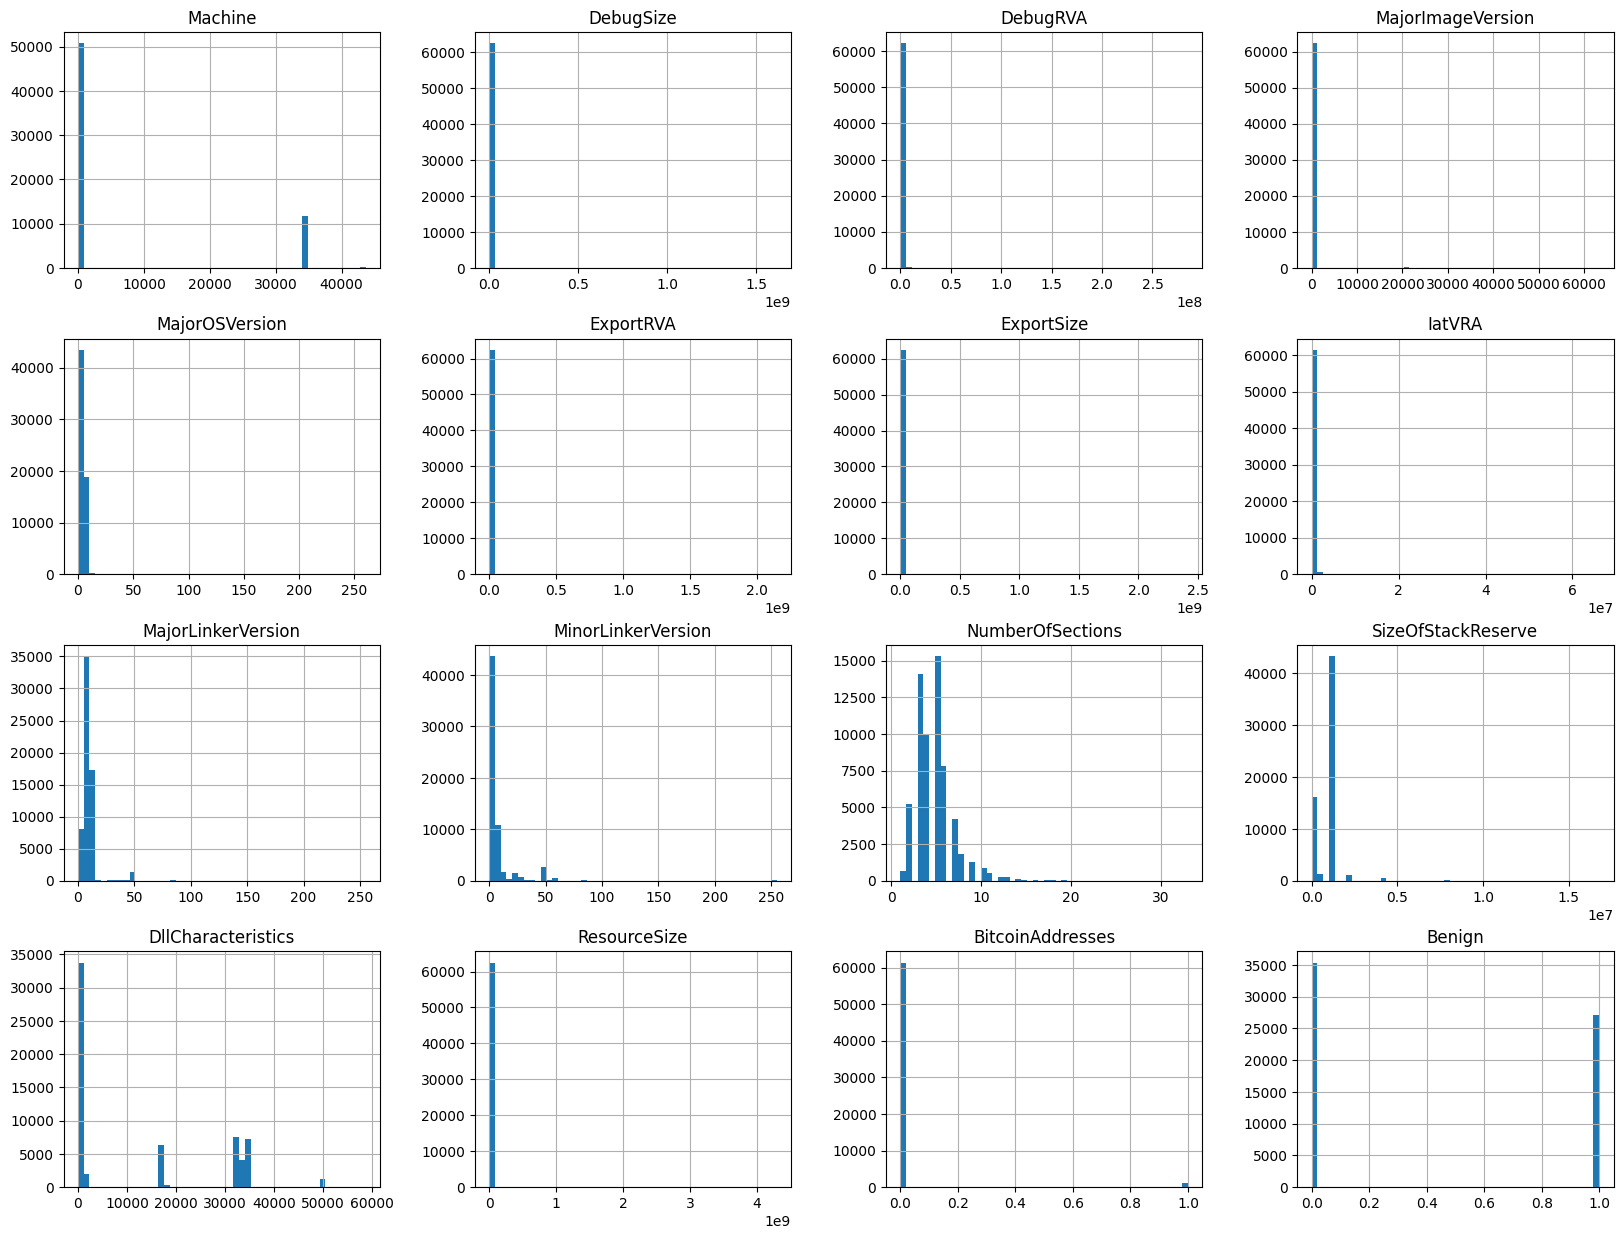

In [7]:
#Lets plot!

df.hist(bins=50, figsize=(20,15))

- The goal here was to do some exploratory analysis of the data, as we can see, it is extremely skewed: 
    - A lof of values are very close to 0 while others are very large
    - Some columns with tall spikes look more like they take on only a handful of distinct values, not continuous ranges (e.g., Machine, DllCharacteristics).
    - Target column *benign* only take 2 values(1 or 0), is considered categorical. 
        - This column will be excluded from the feature matrix(X)
- Based on the information extracted from the analysis we can decide what action will be taken to normalize each column

## Preprocessing:
| **Column**             | **Characteristic**                               | **Preprocessing**                                      |
|------------------------|---------------------------------------------------|--------------------------------------------------------|
| FileName               | Identifier - Irrelevant for Model                | Merge to create id                                     |
| md5Hash                | Identifier - Irrelevant for Model                | Merge to create id                                     |
| Machine                | CPU architecture code (x86, x64, ARM)            | One-hot encode (Map to categories)                     |
| MajorImageVersion      | Small integer (ordinal)                          | Keep numeric, scale                                    |
| MajorOSVersion         | Small integer (ordinal)                          | Keep numeric, scale                                    |
| MajorLinkerVersion     | Small integer (ordinal)                          | Keep numeric, scale                                    |
| MinorLinkerVersion     | Small integer (ordinal)                          | Keep numeric, scale                                    |
| NumberOfSections       | Count of sections in PE file                     | Keep numeric, scale if needed                          |
| DebugSize              | Continuous numeric (Skewed)                      | Log transform + scale                                  |
| DebugRVA               | Continuous numeric (Skewed)                      | Log transform + scale                                  |
| ExportRVA              | Continuous numeric (Skewed)                      | Log transform + scale                                  |
| ExportSize             | Continuous numeric (Skewed)                      | Log transform + scale                                  |
| IatVRA                 | Continuous numeric (Skewed)                      | Log transform + scale                                  |
| ResourceSize           | Continuous numeric (Skewed)                      | Log transform + scale                                  |
| SizeOfStackReserve     | Continuous numeric (Skewed)                      | Log transform + scale                                  |
| DllCharacteristics     | Bitmask of flags (e.g. DEP, ASLR)               | Expand into binary flags (one column per bit)          |
| BitcoinAddresses       | Binary (0/1)                                     | Keep as is                                             |
| Benign                 | Target label (benign vs malware) will flip this so ransomware is target                |Target                                                 |


In [8]:
#preprocessing machine

df["Machine"].value_counts()

Machine
332      50624
34404    11685
452         98
43620       76
0            1
870          1
Name: count, dtype: int64

### Let's start with **machine**
    - This column has labels describing the CPU architecture(332, 34404), which map to x86, x64, ARM etc
    
| **Code** | **Count** | **Architecture**        | **Meaning / Status**                               |
|----------|-----------|--------------------------|-----------------------------------------------------|
| 332      | 50,624    | **x86**                  | Normal, common, keep                                |
| 34404    | 11,685    | **x64** (AMD64)          | Normal, common, keep                                |
| 452      | 98        | **ARMNT** (ARM Thumb)    | Rare but valid, consider keeping                    |
| 43620    | 76        | **ARM64**                | Rare but valid, 64-bit ARM                          |
| 0        | 1         | **Trash**              | Invalid -> placeholder, dropped or flagged -> drop           |
| 870      | 1         | **Unrecognized**       | Weird -> Possibly corrupted, drop             |

- Will use this information to map the numerical values to their proper labels and One-Hot Encode


In [19]:
df.dtypes

FileName              object
md5Hash               object
Machine                int64
DebugSize              int64
DebugRVA               int64
MajorImageVersion      int64
MajorOSVersion         int64
ExportRVA              int64
ExportSize             int64
IatVRA                 int64
MajorLinkerVersion     int64
MinorLinkerVersion     int64
NumberOfSections       int64
SizeOfStackReserve     int64
DllCharacteristics     int64
ResourceSize           int64
BitcoinAddresses       int64
Benign                 int64
dtype: object

### Preprocess ransomware dataset:
    - Clean invalid Machine codes
    - Map Machine to string labels
    - One-hot encode categorical features
    - Save identifiers separately (FileName, md5Hash)
    - Drop identifiers from training set


In [6]:
 # --- Machine ---
df = df[~df['Machine'].isin([0, 870])].copy()  # drop invalid options
    
#map raw codes to string labels
machine_map = {
        332: 'x86',
        34404: 'x64',
        452: 'ARM',
        43620: 'ARM64'
}
#map string to 0-1 labels
df['Machine'] = df['Machine'].map(machine_map)
df = pd.get_dummies(df, columns=['Machine'], prefix='Machine')
    
# --- Identifiers ---
meta = df[['FileName', 'md5Hash']].copy()
df = df.drop(columns=['FileName', 'md5Hash'])

#Create a new target column Ransom
df["Ransomware"] = df["Benign"].map({1:0, 0:1})
df = df.drop(columns=["Benign"])

### Correlation Analysis

I want to identify which **features (columns)** are most related to the **target value** (`Benign` classification). Will use corr() method

- **Closer to +1 → more likely ransomware**  
- **Closer to -1 → more likely benign**

---
#### Target column was flipped - so now:
#### Target Definition
| Label | Meaning |
|--------|----------|
| `1` | Ransomware |
| `0` | Benign |

---

#### Correlation Strength Guide

|Range | Strength | Interpretation |
|--------|----------| -------------- |
| 0.0 – 0.2 | Very Weak | Essentially noise |
| 0.2 – 0.4 | Weak to Moderate | Some relationship, but not strong |
| 0.4 – 0.6 | Moderate | Noticeable trend |
| 0.6 – 0.8 | Strong | Clear pattern |
| 0.8 – 1.0 | Very Strong | Almost deterministic |


In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 62483 entries, 0 to 62484
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   DebugSize           62483 non-null  int64
 1   DebugRVA            62483 non-null  int64
 2   MajorImageVersion   62483 non-null  int64
 3   MajorOSVersion      62483 non-null  int64
 4   ExportRVA           62483 non-null  int64
 5   ExportSize          62483 non-null  int64
 6   IatVRA              62483 non-null  int64
 7   MajorLinkerVersion  62483 non-null  int64
 8   MinorLinkerVersion  62483 non-null  int64
 9   NumberOfSections    62483 non-null  int64
 10  SizeOfStackReserve  62483 non-null  int64
 11  DllCharacteristics  62483 non-null  int64
 12  ResourceSize        62483 non-null  int64
 13  BitcoinAddresses    62483 non-null  int64
 14  Machine_ARM         62483 non-null  bool 
 15  Machine_ARM64       62483 non-null  bool 
 16  Machine_x64         62483 non-null  bool 
 17

In [11]:
corr = df.corr(numeric_only=True)

target_corr = corr['Ransomware'].sort_values(ascending=False)
print(target_corr)

Ransomware            1.000000
Machine_x86           0.552389
SizeOfStackReserve    0.282173
MinorLinkerVersion    0.111288
NumberOfSections      0.020430
ExportRVA             0.012547
ExportSize            0.012457
DebugSize             0.003500
ResourceSize          0.002168
Machine_ARM64        -0.039852
Machine_ARM          -0.045262
MajorImageVersion    -0.049602
BitcoinAddresses     -0.054821
DebugRVA             -0.072779
IatVRA               -0.084621
DllCharacteristics   -0.261101
MajorLinkerVersion   -0.296911
MajorOSVersion       -0.398068
Machine_x64          -0.547377
Name: Ransomware, dtype: float64


**These are the columns with the higher correlation**
---

More related to benign samples (some relationship but not strong)
- Machine_x64           0.547377
- MajorOSVersion        0.398068
- MajorLinkerVersion    0.296911

More related to ransomware samples:

- Machine_x86          -0.552389

***This shows me that there isnt a single defining feature on ransomware files (the model will have to learn a combination of behaviors)***



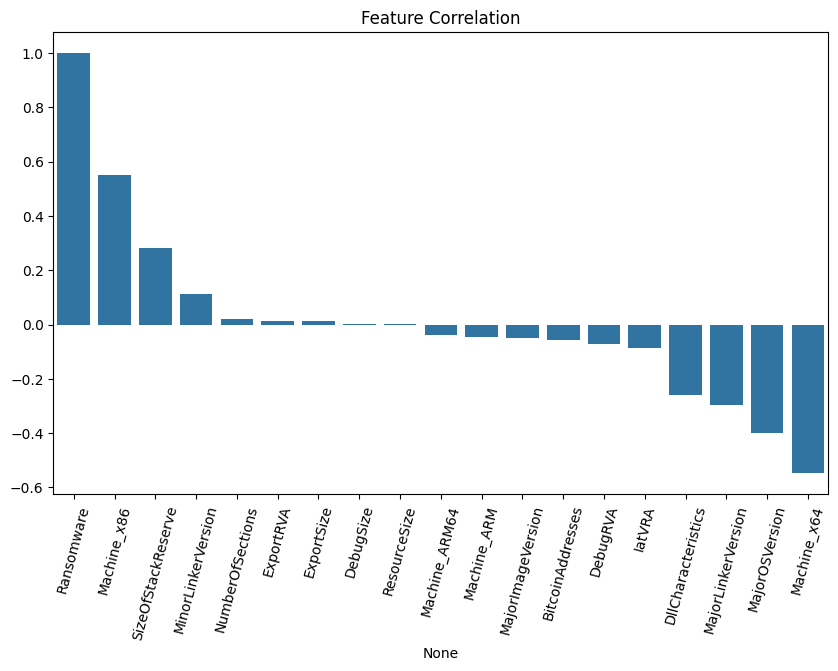

In [12]:
plt.figure(figsize=(10,6))
sns.barplot(x=target_corr.index, y=target_corr.values)
plt.xticks(rotation=75)
plt.title("Feature Correlation")
plt.show()

### **Creating our train/test data**

In [7]:
# -- split train-test data --

X = df.drop(columns=['Ransomware']) #train
y = df['Ransomware'] #target

#stratify handles class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

#------- Random Forest -------


In [ ]:
 #Randomized search will sample random integers in the range given for the best  parameters 


param_dist = {'n_estimators': sp_randint(200, 1000),
    'max_depth': sp_randint(10, 60),
    'min_samples_split': sp_randint(2, 10),
    'min_samples_leaf': sp_randint(1, 4)
}


#instance of Random forest model 
rf = RandomForestClassifier(random_state=42)

#Randomized search will sample random integers in the range given for the best  parameters 
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,               # number of random combinations to try
    cv=5,                    # 5-fold cross-validation
    scoring="matthews_corrcoef",
    verbose=2,
    random_state=42,
    n_jobs=-1
)
rf_random.fit(X_train, y_train)

print(rf_random.best_params_)
print(rf_random.best_score_)

#Based on randomized search -> best parameters:
rf_best = rf_random.best_estimator_ #trained model instance
y_pred = rf_best.predict(X_test)

print(rf_random.best_params_)



Fitting 5 folds for each of 50 candidates, totalling 250 fits


[CV] END max_depth=48, min_samples_leaf=1, min_samples_split=8, n_estimators=306; total time=   5.7s
[CV] END max_depth=48, min_samples_leaf=1, min_samples_split=8, n_estimators=306; total time=   5.8s
[CV] END max_depth=48, min_samples_leaf=1, min_samples_split=8, n_estimators=306; total time=   5.9s
[CV] END max_depth=48, min_samples_leaf=1, min_samples_split=8, n_estimators=306; total time=   5.7s
[CV] END max_depth=48, min_samples_leaf=1, min_samples_split=8, n_estimators=306; total time=   6.1s
[CV] END max_depth=17, min_samples_leaf=1, min_samples_split=6, n_estimators=814; total time=  15.4s
[CV] END max_depth=17, min_samples_leaf=1, min_samples_split=6, n_estimators=814; total time=  15.6s
[CV] END max_depth=17, min_samples_leaf=1, min_samples_split=6, n_estimators=814; total time=  15.8s
[CV] END max_depth=28, min_samples_leaf=3, min_samples_split=4, n_estimators=658; total time=  12.2s
[CV] END max_depth=28, min_samples_leaf=3, min_samples_split=4, n_estimators=658; total tim

In [8]:
#Best RF model built using rf_random

rf = RandomForestClassifier(max_depth= 30, 
                            min_samples_leaf= 1, 
                            min_samples_split= 3, 
                            n_estimators= 252,
                            random_state=42)

# Train
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)

print("\n--- Random Forest ---")
print(classification_report(y_test, y_pred, digits=3))
print(confusion_matrix(y_test, y_pred))





--- Random Forest ---
              precision    recall  f1-score   support

           0      0.997     0.996     0.996     10848
           1      0.997     0.997     0.997     14146

    accuracy                          0.997     24994
   macro avg      0.997     0.997     0.997     24994
weighted avg      0.997     0.997     0.997     24994

[[10803    45]
 [   36 14110]]


-> Generate Confusion Matrix <-

In [18]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Benign', 'Ransomware']
)
fig, ax = plt.subplots(figsize=(5, 4)) #fig size

disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title("Random Forest Confusion Matrix", fontsize=12)
ax.set_xlabel("Predicted label", fontsize=11)
ax.set_ylabel("True label", fontsize=11)

plt.tight_layout()
plt.savefig("rf_confusion_matrix_1.pdf")
plt.close()

#----- XGBoost -----#


In [9]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost import XGBClassifier

xgb = XGBClassifier(
    random_state=42,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'  # suppresses warning

)

param_grid = {
    "n_estimators":  [100, 200],
    "max_depth": [4,6,8],
    "learning_rate": [0.05, 0.1],

}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="matthews_corrcoef",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best CV MCC:", grid.best_score_)
print("Best parameters:", grid.best_params_)

xgb_best = grid.best_estimator_
y_pred = xgb_best.predict(X_test)

#evaluate

print(classification_report(y_test, y_pred, digits=4))
print("Test MCC:", matthews_corrcoef(y_test, y_pred))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best CV MCC: 0.9913682761479198
Best parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}
              precision    recall  f1-score   support

           0     0.9958    0.9952    0.9955     10848
           1     0.9963    0.9968    0.9966     14146

    accuracy                         0.9961     24994
   macro avg     0.9961    0.9960    0.9961     24994
weighted avg     0.9961    0.9961    0.9961     24994

Test MCC: 0.9921001657443609


### Results of General with avarage parameters 
cv_scores = cross_val_score(
    xgb,
    X_train,
    y_train,
    cv=cv,
    scoring="matthews_corrcoef"
)
print(f"CV MCC scores: {cv_scores}")
print(f"Mean CV MCC: {np.mean(cv_scores):.3f}")
print(f"Std CV MCC: {np.std(cv_scores):.3f}")

CV MCC scores: [0.99104102 0.99158667 0.9905033  0.98968407 0.99022528]
Mean CV MCC: 0.991
Std CV MCC: 0.001

best_params = [
    n_estimators=200,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
]

In [6]:
#SVM with 5-cv
# LinearSVC is MUCH faster than SVC(kernel='linear')

from sklearn.model_selection import GridSearchCV


fast_svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LinearSVC(random_state=42, max_iter=20000, dual=False, tol=1e-3, class_weight="balanced"))
])

param_dist_fast = {
    'svm__C': [0.001, 0.01, 0.1, 1, 10, 100] # Discrete values are faster than loguniform
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mcc_scorer = make_scorer(matthews_corrcoef)

svm_search = GridSearchCV(
    estimator=fast_svm_pipe,
    param_grid=param_dist_fast,
    scoring=mcc_scorer,
    cv=cv,           
    n_jobs=-1        # Uses all CPU cores
)

svm_search.fit(X_train, y_train)

print("\n--- Best SVM Parameters Found ---")
best_params = svm_search.best_params_
print(best_params)
print("Best CV MCC:", svm_search.best_score_)


--- Best SVM Parameters Found ---
{'svm__C': 0.1}
Best CV MCC: 0.75016472236949


### SVM Performance Comparison

Two SVM configurations with different regularization strengths were evaluated to assess sensitivity to the hyperparameter C.


#### SVM (C = 10)

- **Accuracy:** 0.882  
- **Weighted F1-score:** 0.882  
- **Matthews Correlation Coefficient (MCC):** 0.761  


| Class | Precision | Recall | F1-score | Support |
|------:|----------:|-------:|---------:|--------:|
| 0 | 0.904 | 0.816 | 0.858 | 10,848 |
| 1 | 0.869 | 0.933 | 0.900 | 14,146 |

accuracy                          0.882     24994
macro avg      0.886     0.875     0.879     24994
weighted avg      0.884     0.882     0.882     24994

#### SVM (C = 0.1)

- **Best Cross-Validation MCC:** 0.750  
- **Accuracy:** 0.883  
- **Weighted F1-score:** 0.882  
- **Matthews Correlation Coefficient (MCC):** 0.761  

| Class | Precision | Recall | F1-score | Support |
|------:|----------:|-------:|---------:|--------:|
| 0 | 0.904 | 0.816 | 0.858 | 10,848 |
| 1 | 0.869 | 0.934 | 0.900 | 14,146 |

---

**Summary:**  
Varying the regularization parameter **C** from 10 to 0.1 results in negligible differences in test-set performance, with identical MCC values and nearly identical class-wise metrics across both configurations.


In [7]:

# 1. Use the best model found by the search to make predictions
from sklearn.metrics import matthews_corrcoef


y_pred = svm_search.predict(X_test)

# 2. Generate the report

report = classification_report(y_test, y_pred, digits=3)

print("--- SVM Final Performance (Best Params) ---")
print(report)

mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.3f}")


--- SVM Final Performance (Best Params) ---
              precision    recall  f1-score   support

           0      0.904     0.816     0.858     10848
           1      0.869     0.934     0.900     14146

    accuracy                          0.883     24994
   macro avg      0.886     0.875     0.879     24994
weighted avg      0.884     0.883     0.882     24994

Matthews Correlation Coefficient (MCC): 0.761


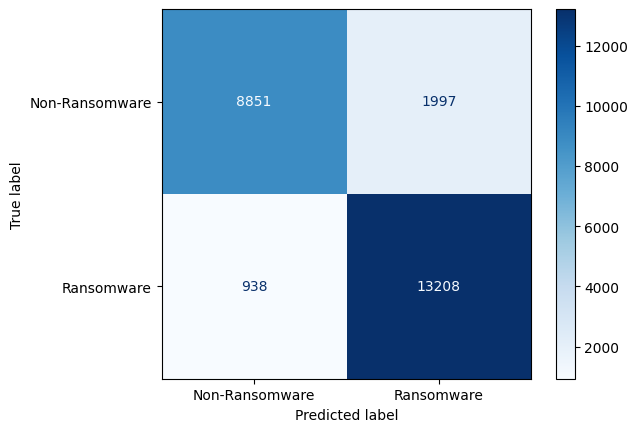

In [10]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Non-Ransomware', 'Ransomware']
)
disp.plot(cmap='Blues', values_format='d')


### Using **SHAP** 

- Since single features are not deterministic, SHAP will help us understand which **combination** of features drives the models to make preditions
- We will also be able to see relationships that simple correlation methods can miss




In [17]:
X.dtypes

DebugSize             int64
DebugRVA              int64
MajorImageVersion     int64
MajorOSVersion        int64
ExportRVA             int64
ExportSize            int64
IatVRA                int64
MajorLinkerVersion    int64
MinorLinkerVersion    int64
NumberOfSections      int64
SizeOfStackReserve    int64
DllCharacteristics    int64
ResourceSize          int64
BitcoinAddresses      int64
Machine_ARM            bool
Machine_ARM64          bool
Machine_x64            bool
Machine_x86            bool
dtype: object

Machine_ARM64          bool
Machine_x64            bool
Machine_x86            bool

-> Boolean types are being interpreted as objects by SHAP. 
- Need to turn everything to int before proceeding

In [11]:
bool_cols = X.select_dtypes('bool').columns

X_fixed = X.copy()

for col in bool_cols:
    X_fixed[col] = X_fixed[col].astype(int)

X_fixed.dtypes

DebugSize             int64
DebugRVA              int64
MajorImageVersion     int64
MajorOSVersion        int64
ExportRVA             int64
ExportSize            int64
IatVRA                int64
MajorLinkerVersion    int64
MinorLinkerVersion    int64
NumberOfSections      int64
SizeOfStackReserve    int64
DllCharacteristics    int64
ResourceSize          int64
BitcoinAddresses      int64
Machine_ARM           int64
Machine_ARM64         int64
Machine_x64           int64
Machine_x86           int64
dtype: object

In [12]:
import shap

# Reorder and align columns to the model’s training schema
X_aligned = X_fixed[xgb_best.feature_names_in_]

# Sample subset for SHAP
X_sample = X_aligned.sample(n=500, random_state=42)

# Run SHAP again
explainer = shap.Explainer(xgb_best, X_sample)
shap_values = explainer(X_sample)

shap_values_ransom = shap_values

#check to comfirm which class SHAP is predicting (have to select 0 or 1 for ransom or benign)
print(shap_values.shape)
print(X_sample.shape)

(500, 18)
(500, 18)


In [39]:


# Plot feature importance for ransomware predictions
plt.figure(figsize=(7,4))
shap.plots.bar(shap_values_ransom, show=False)
plt.tight_layout()
plt.savefig("shap_bar_XGB_1.pdf", format="pdf", bbox_inches="tight")
plt.close()

plt.figure(figsize=(7,6))
shap.plots.beeswarm(shap_values_ransom, show=False)
plt.tight_layout()
plt.savefig("shap_bee_XGB_1.pdf", format="pdf", bbox_inches="tight")
plt.close()



### SHAP Feature Importance Analysis — Ransomware Classification

This SHAP summary plot visualizes the **most influential features** driving the model’s predictions toward **ransomware** (`class = 1`).  
Each bar represents the **average magnitude** of a feature’s contribution to predicting ransomware across 500 random samples.

---

#### Overview
The model’s behavior suggests that ransomware executables are characterized by **distinct binary structure patterns**, particularly in how they handle DLLs, linking, and debug information.  
No single feature fully determines ransomware classification — instead, a combination of moderately strong indicators contributes to the final prediction.

---

#### Top Influential Features

| Rank | Feature | Description | Interpretation |
|------|----------|--------------|----------------|
| **1** | `DllCharacteristics` | Flags describing how the binary handles DLL loading and security features | Strongest ransomware indicator. Certain combinations of DLL flags (e.g., dynamic linking or missing ASLR/DEP protection) appear more frequently in ransomware samples. |
| **2** | `MajorLinkerVersion` | Version of the linker used to compile the executable | Older or non-standard linker versions are associated with malicious or obfuscated builds. |
| **3** | `Machine_x86` | Architecture flag indicating 32-bit executable | 32-bit architectures occur more often in ransomware, suggesting older compilation targets or attempts at broader compatibility. |
| **4** | `DebugSize` | Size of the debug section | Ransomware often strips or minimizes debug data to hinder reverse engineering, making this a strong signal. |
| **5** | `Machine_x64` | Architecture flag indicating 64-bit executable | Secondary influence; some modern ransomware variants target 64-bit systems but less frequently than 32-bit. |
| **6** | `ResourceSize` | Total size of embedded resources in the PE file | Embedded payloads or encrypted assets in ransomware cause resource size deviations. |
| **7** | `DebugRVA` | Address of the debug data | Non-standard debug data placement patterns appear in ransomware samples. |
| **8** | `MajorOSVersion` | Target operating system version | Suggests ransomware often targets specific or older OS versions. |
| **9** | `MajorImageVersion` | PE image version field | Minor correlation; may indicate compilation differences between benign and malicious samples. |
| **10** | `Sum of 9 other features` | Combined weaker signals | Cumulatively adds predictive value but with less individual impact. |

---

#### Interpretation Summary
- **Architecture and linking properties** (`Machine_x86`, `MajorLinkerVersion`, `DllCharacteristics`) are key differentiators between ransomware and benign samples.  
- **Debug-related features** (`DebugSize`, `DebugRVA`) further distinguish ransomware due to stripped or irregular debug data.  
- These patterns align with typical malware development behavior, where binaries are deliberately built with minimal metadata and compatibility across older systems.

---

#### Conclusion
The SHAP analysis confirms that the model is learning **legitimate structural indicators** of ransomware, rather than relying on noise or data leakage.  
It demonstrates that **ransomware classification relies on multiple moderate signals** working together — particularly binary architecture, DLL handling, and debug metadata — to form an accurate detection pattern.


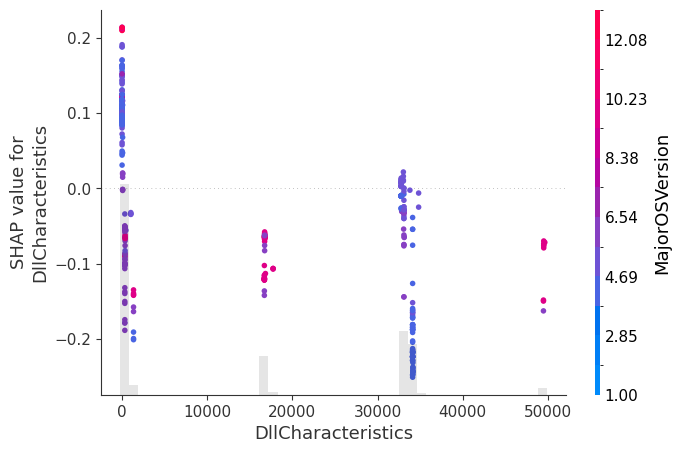

In [32]:

#to undertand better the weight of DLL on detection
shap.plots.scatter(shap_values_ransom[:, "DllCharacteristics"], color=shap_values_ransom)

### Axes meaning

**X-axis** → DllCharacteristics value:
The actual raw values from your dataset (e.g., PE header flags).

**Y-axis** → SHAP value:
How much that DllCharacteristics value pushed the model toward or away from ransomware.

**Positive SHAP value** → pushed prediction toward ransomware

**Negative SHAP value** → pushed prediction away from ransomware

#### Color → MajorOSVersion:
- Blue = lower OS version (older),
- Pink/red = higher OS version (newer).
---
#### Observations

1. **Low or near-zero `DllCharacteristics` values**  
   - Produce **positive SHAP values**, pushing predictions toward *ransomware*.  
   - Indicates that binaries lacking modern DLL protections (e.g., ASLR, DEP) are strong ransomware indicators.

2. **Mid-range values (20,000–40,000)**  
   - Show SHAP values near zero or slightly negative.  
   - Suggests more standard DLL-handling patterns typical of non-ransomware malware.

3. **Interaction with `MajorOSVersion`**  
   - Red/pink points (newer OS versions) appear higher on the SHAP axis → these amplify the ransomware signal.  
   - Blue points (older OS versions) cluster lower, showing weaker influence.

---

#### Summary

> Ransomware samples with low or missing `DllCharacteristics` flags are more confidently classified as malicious, especially when targeting newer Windows OS versions.  
> This pattern implies that many ransomware executables **disable or omit modern DLL protection mechanisms** to maintain compatibility and ensure execution on updated systems.


### SHAP Quantitative Analysis of Feature-Space Overlap


Mean absolute SHAP values were computed to obtain global feature importance rankings. The cumulative importance of the top features was compared across datasets to measure discriminative concentration. The goal is to observe if reduced concentration and increased distribution of SHAP values in Dataset 3 provide quantitative evidence of feature-space overlap between ransomware and other malware.


In [ ]:

# absolute SHAP values
abs_shap = np.abs(shap_values.values)

# mean absolute SHAP per feature
mean_abs_shap = abs_shap.mean(axis=0)

# put into dataframe
shap_df = pd.DataFrame({
    "feature": X_sample.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values(by="mean_abs_shap", ascending=False)

shap_df.head(10)

,feature,mean_abs_shap
11,DllCharacteristics,2.085212
12,ResourceSize,0.969675
7,MajorLinkerVersion,0.951915
0,DebugSize,0.894978
16,Machine_x64,0.838011
17,Machine_x86,0.784592
9,NumberOfSections,0.678235
6,IatVRA,0.630514
1,DebugRVA,0.519965
3,MajorOSVersion,0.467893


In [14]:
# Sum of Top 5 SHAP Importance

top5_sum = shap_df.head(5)["mean_abs_shap"].sum()
total_sum = shap_df["mean_abs_shap"].sum()

top5_ratio = top5_sum / total_sum

print("Top 5 contribution ratio:", top5_ratio)


Top 5 contribution ratio: 0.5525271853033565


In [15]:
# Variance of SHAP per Feature

shap_variance = abs_shap.var(axis=0)

variance_df = pd.DataFrame({
    "feature": X_sample.columns,
    "variance": shap_variance
}).sort_values(by="variance", ascending=False)

variance_df.head(10)


,feature,variance
11,DllCharacteristics,0.836480
12,ResourceSize,0.628621
16,Machine_x64,0.529327
17,Machine_x86,0.444860
7,MajorLinkerVersion,0.321162
0,DebugSize,0.319279
6,IatVRA,0.291170
9,NumberOfSections,0.251008
3,MajorOSVersion,0.151582
1,DebugRVA,0.109832


### Strong Signals

- DLL again shows high variance and highest mean.
- DLL sharply separates benign vs ransomware in many cases. The model is confidently using it.
- Variance values are substantial (0.83, 0.63, etc). That means some samples are heavily driven by certain headers. 